In [113]:
import os
import pandas as pd

from darts import TimeSeries
from darts.models import NaiveSeasonal, ARIMA, AutoARIMA, ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler

from dotenv import load_dotenv
from entsoe import EntsoePandasClient

import matplotlib.pyplot as plt

load_dotenv()
API_KEY = os.environ.get('API_KEY')
client = EntsoePandasClient(api_key=API_KEY)

# 5 years, 3 years, 1 year
periods = [('20160101', '20210101'), ('20180101', '20210101'), ('20200101', '20210101')]
country_code = 'CH'

def get_df_load(period):
    start = pd.Timestamp(period[0], tz='Europe/Zurich')
    end = pd.Timestamp(period[1], tz='Europe/Zurich')
    return client.query_load(country_code, start=start, end=end)

In [77]:
# Get 1 year load data
df = get_df_load(periods[2])
df = df.rename_axis('time')
df = df.tz_localize(None)
df.reset_index(inplace=True)

In [78]:
# Find duplicated rows
print(f"There are {df.time.duplicated().sum()} duplicated rows")
duplicated_index = df[df.time.duplicated()].index.values[0]
df.loc[duplicated_index-1:duplicated_index+1]

There are 1 duplicated rows


,time,Actual Load
7153,2020-10-25 02:00:00,6957.0
7154,2020-10-25 02:00:00,7112.0
7155,2020-10-25 03:00:00,6886.0


In [79]:
# Find missing timestamp if the interval is greater than 1 hour
print(f"There are {len(df[pd.to_datetime(df['time']).diff() > '01:00:00'].index.values)} missing rows")
missing = df[pd.to_datetime(df['time']).diff() > '01:00:00'].index.values[0]
df.loc[missing-1:missing+1]

There are 1 missing rows


,time,Actual Load
2113,2020-03-29 01:00:00,7051.0
2114,2020-03-29 03:00:00,6958.0
2115,2020-03-29 04:00:00,7042.0


In [83]:
start = pd.Timestamp(periods[2][0])
end = pd.Timestamp(periods[2][1])

df_ts = pd.DataFrame(pd.date_range(start=start, end=end, freq='1H')[:-1], columns=['time'])

In [101]:
df_cleaned = pd.merge(df_ts, df.drop_duplicates(subset='time'), on='time', how='left').fillna(method='ffill')

<Figure size 720x720 with 0 Axes>

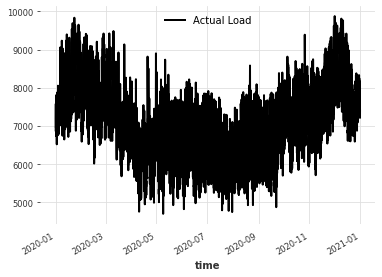

<Figure size 720x720 with 0 Axes>

In [102]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df_cleaned, 'time', 'Actual Load')
series.plot()
plt.figure(figsize=(10,10))
#
# # Set aside the last 36 months as a validation series
# train, val = series[:-36], series[-36:]

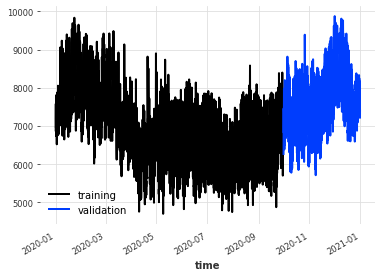

In [103]:
train, val = series.split_before(pd.Timestamp('20201001'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

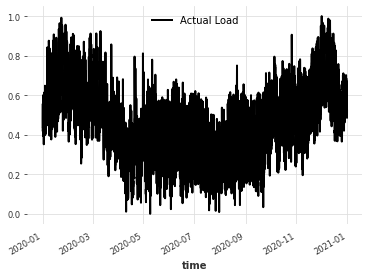

In [109]:
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_scaled.plot()

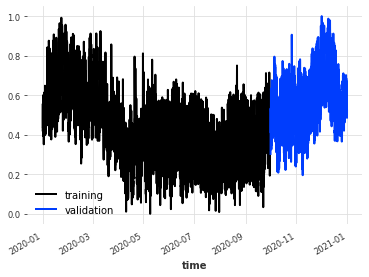

In [110]:
train_scaled, val_scaled = series_scaled.split_before(pd.Timestamp('20201001'))
train_scaled.plot(label='training')
val_scaled.plot(label='validation')
plt.legend();

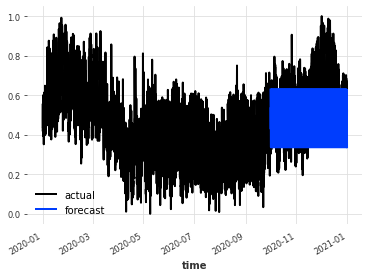

In [111]:
naive_season = NaiveSeasonal(K=12)
naive_season.fit(train_scaled)
naive_season_forecast = naive_season.predict(len(val_scaled))
series_scaled.plot(label='actual')
naive_season_forecast.plot(label='forecast')

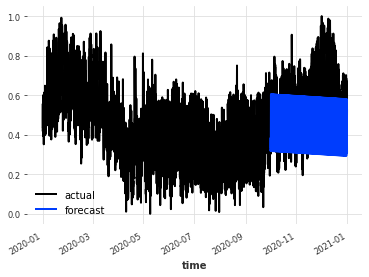

In [114]:
# train.values().min()
naive_season = ExponentialSmoothing()
naive_season.fit(train_scaled)
naive_season_forecast = naive_season.predict(len(val_scaled))
series_scaled.plot(label='actual')
naive_season_forecast.plot(label='forecast')